In [1]:
from qiskit.circuit.library import QAOAAnsatz

import parity_network
import importlib
import numpy as np

In [2]:
num_qubits = 10

Parities and Weights of the Hamiltonian:
{'0000000000': 0.25, '0010000000': 0.125, '0001000000': 0.125, '1100000000': -0.25, '1010000000': 0.125, '1001000000': -0.125, '0110000000': -0.125, '0101000000': 0.125, '1110000000': -0.125, '1101000000': -0.125}

Forward Circuit with Rz gates:
                                                                            »
q_0: ──────■─────────────────────────■──────────────────■───────────────────»
         ┌─┴─┐     ┌──────────────┐  │                  │                   »
q_1: ────┤ X ├─────┤ Rz((-0.5)*γ) ├──┼──────────────────┼──────────■────────»
     ┌───┴───┴────┐└──────────────┘┌─┴─┐┌────────────┐  │        ┌─┴─┐      »
q_2: ┤ Rz(0.25*γ) ├────────────────┤ X ├┤ Rz(0.25*γ) ├──┼────────┤ X ├──────»
     ├────────────┤                └───┘└────────────┘┌─┴─┐┌─────┴───┴─────┐»
q_3: ┤ Rz(0.25*γ) ├───────────────────────────────────┤ X ├┤ Rz((-0.25)*γ) ├»
     └────────────┘                                   └───┘└───────────────┘»
q_4: ──────

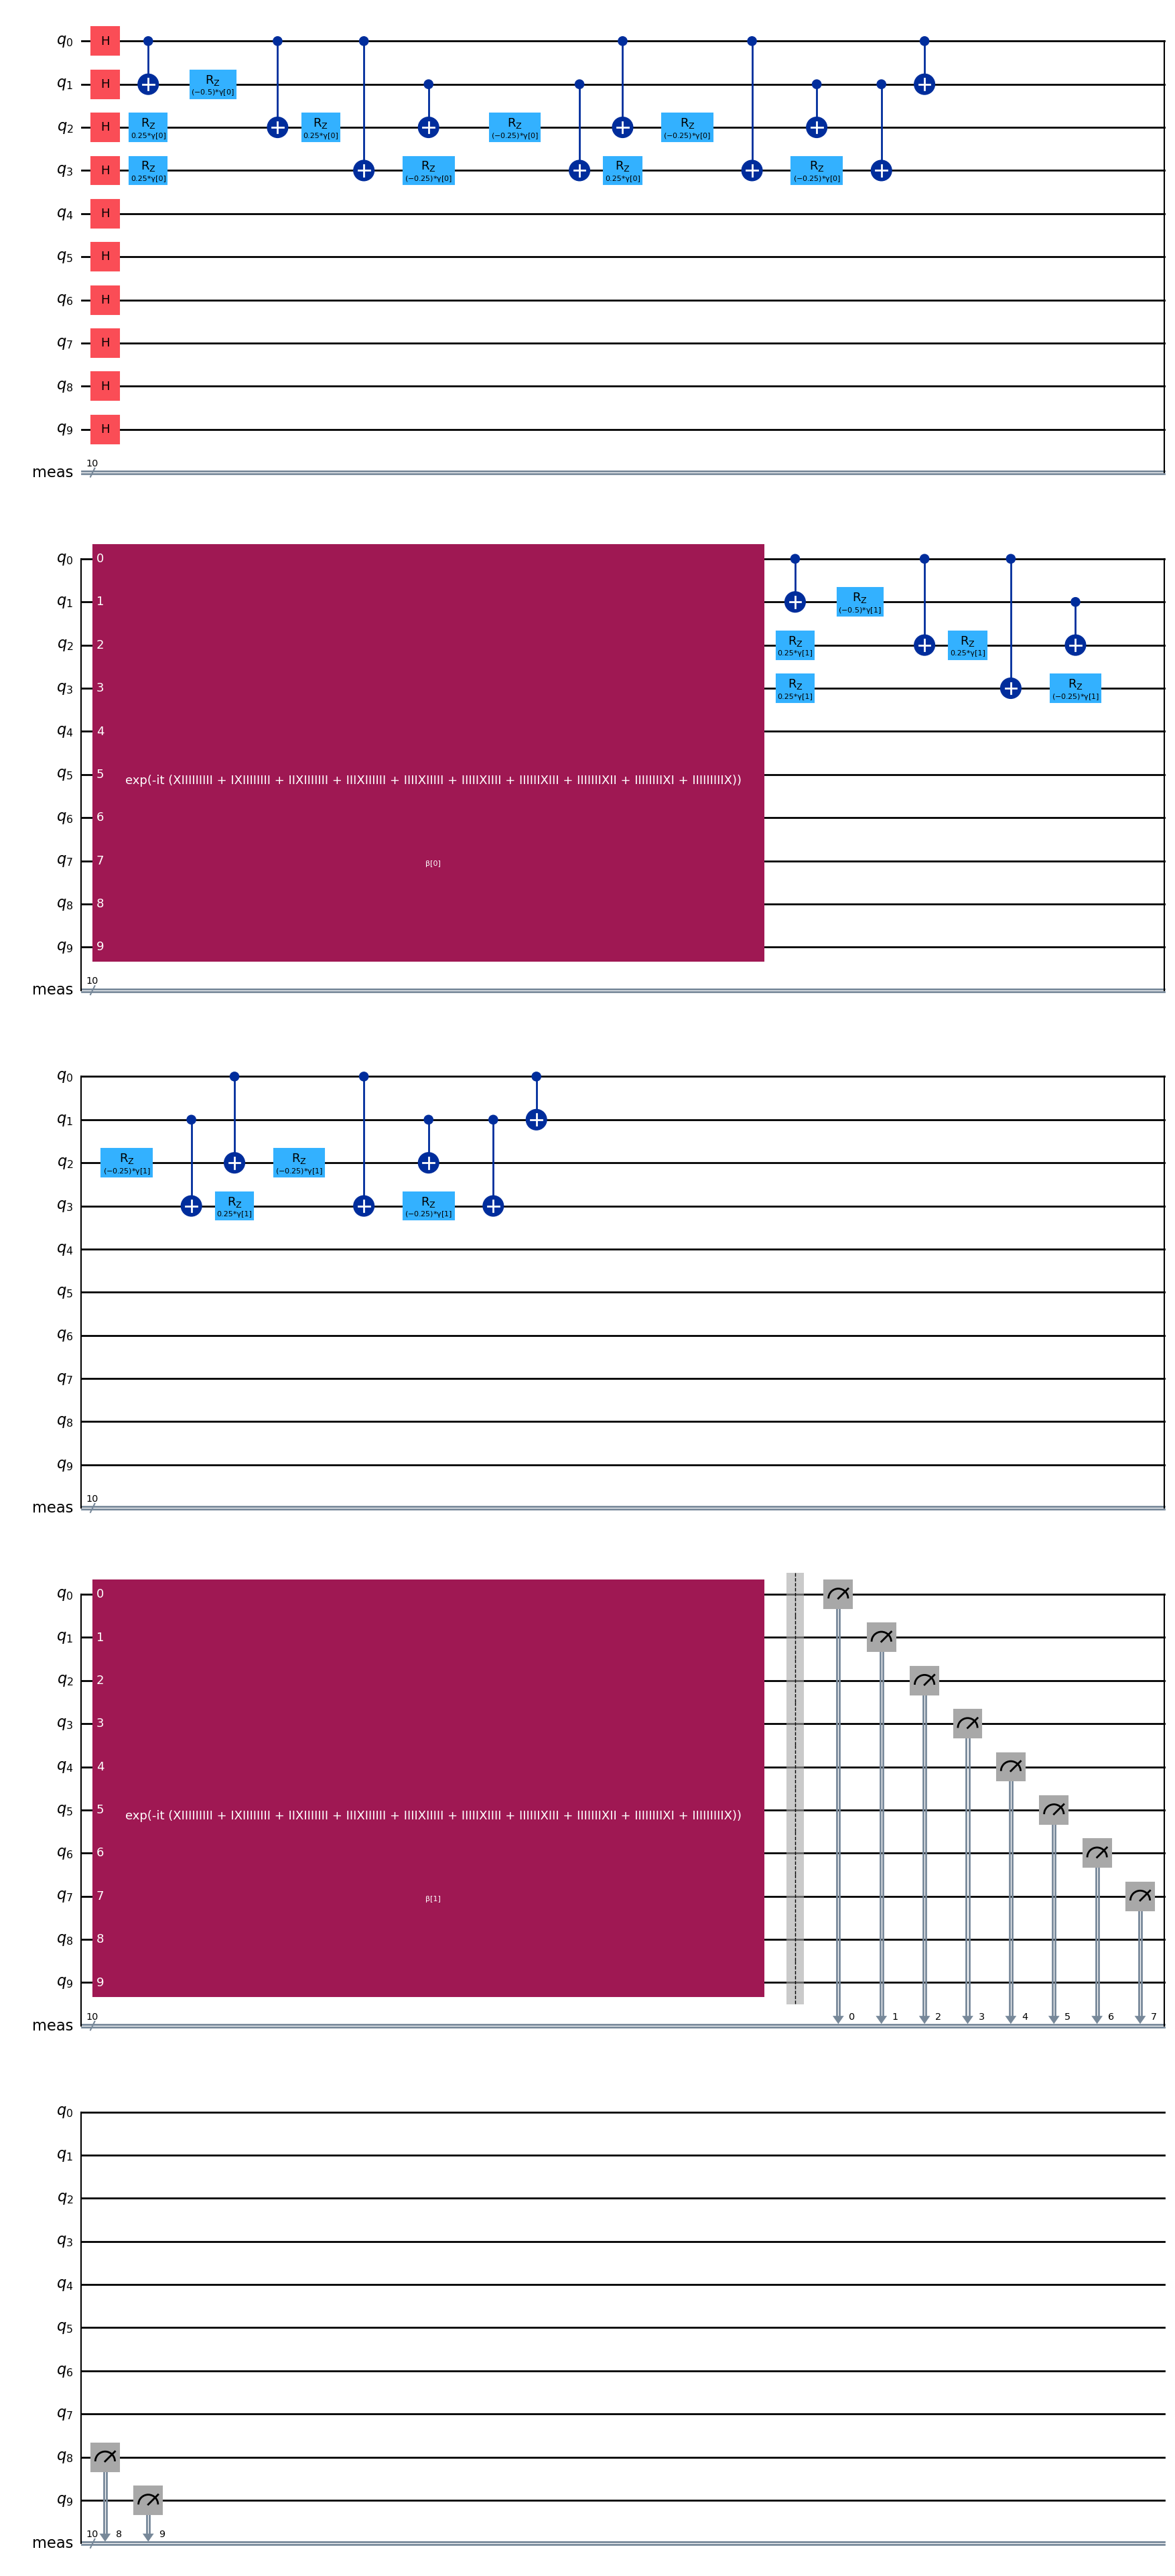

In [3]:
importlib.reload(parity_network)

parity, term_dict = parity_network.main(num_qubits)

parity_ansatz = QAOAAnsatz(parity, reps=2)
parity_ansatz.measure_all()

parity_ansatz.decompose().draw("mpl")

In [4]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_observable(term_dict, n_qubits):
    """Converts a dictionary of bitstrings and weights into a Qiskit SparsePauliOp observable."""
    pauli_list = []
    coeff_list = []
    for bitstring, weight in term_dict.items():
        pauli_str = ["I"] * n_qubits
        for i, bit in enumerate(bitstring):
            if bit == "1":
                pauli_str[n_qubits - 1 - i] = "Z"
        pauli_list.append("".join(pauli_str))
        coeff_list.append(weight)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)

In [5]:
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.compiler import transpile

backend = AerSimulator()
estimator = AerEstimator()
estimator.options.shots = 10000

parity_ansatz_isa = transpile(parity_ansatz, backend=backend)

obs = get_hamiltonian_observable(term_dict, num_qubits)
print(obs)

SparsePauliOp(['IIIIIIIIII', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IIIIIIIZZZ', 'IIIIIIZIZZ'],
              coeffs=[ 0.25 +0.j,  0.125+0.j,  0.125+0.j, -0.25 +0.j,  0.125+0.j, -0.125+0.j,
 -0.125+0.j,  0.125+0.j, -0.125+0.j, -0.125+0.j])


In [6]:
parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}


def initialize_cost_history_dict(cost_history_dict):
    cost_history_dict["iters"] = 0
    cost_history_dict["cost_history"] = []

In [7]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator, cost_history_dict):

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    cost_history_dict["iters"] += 1
    cost_history_dict["cost_history"].append(cost)
    print(f"Iters {cost_history_dict['iters']}: Current cost: {cost}")

    return cost

In [15]:
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(parity_cost_history_dict)

result_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, estimator, parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.48828125
Iters 2: Current cost: 0.6142578125
Iters 3: Current cost: 0.482421875
Iters 4: Current cost: 0.3671875
Iters 5: Current cost: 0.1796875
Iters 6: Current cost: 0.115234375
Iters 7: Current cost: 0.099609375
Iters 8: Current cost: 0.13671875
Iters 9: Current cost: 0.3720703125
Iters 10: Current cost: 0.2744140625
Iters 11: Current cost: 0.244140625
Iters 12: Current cost: 0.1171875
Iters 13: Current cost: 0.1376953125
Iters 14: Current cost: 0.0693359375
Iters 15: Current cost: 0.109375
Iters 16: Current cost: 0.0263671875
Iters 17: Current cost: 0.111328125
Iters 18: Current cost: 0.0224609375
Iters 19: Current cost: 0.0322265625
Iters 20: Current cost: 0.0244140625
Iters 21: Current cost: 0.03515625
Iters 22: Current cost: 0.029296875
Iters 23: Current cost: 0.029296875
Iters 24: Current cost: 0.0224609375
Iters 25: Current cost: 0.0263671875
Iters 26: Current cost: 0.0302734375
Iters 27: Current cost: 0.0341796875
Iters 28: Current cost: 0.02734375
I

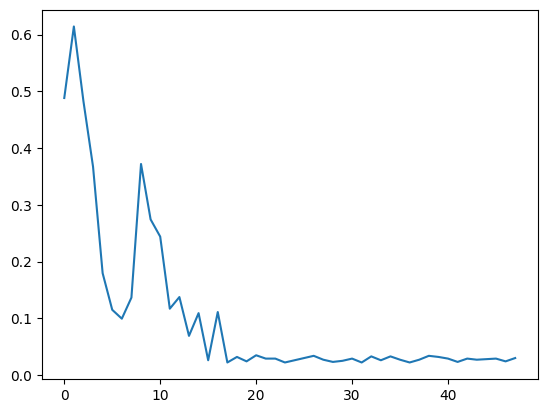

In [16]:
import matplotlib.pyplot as plt

plt.plot(parity_cost_history_dict["cost_history"])

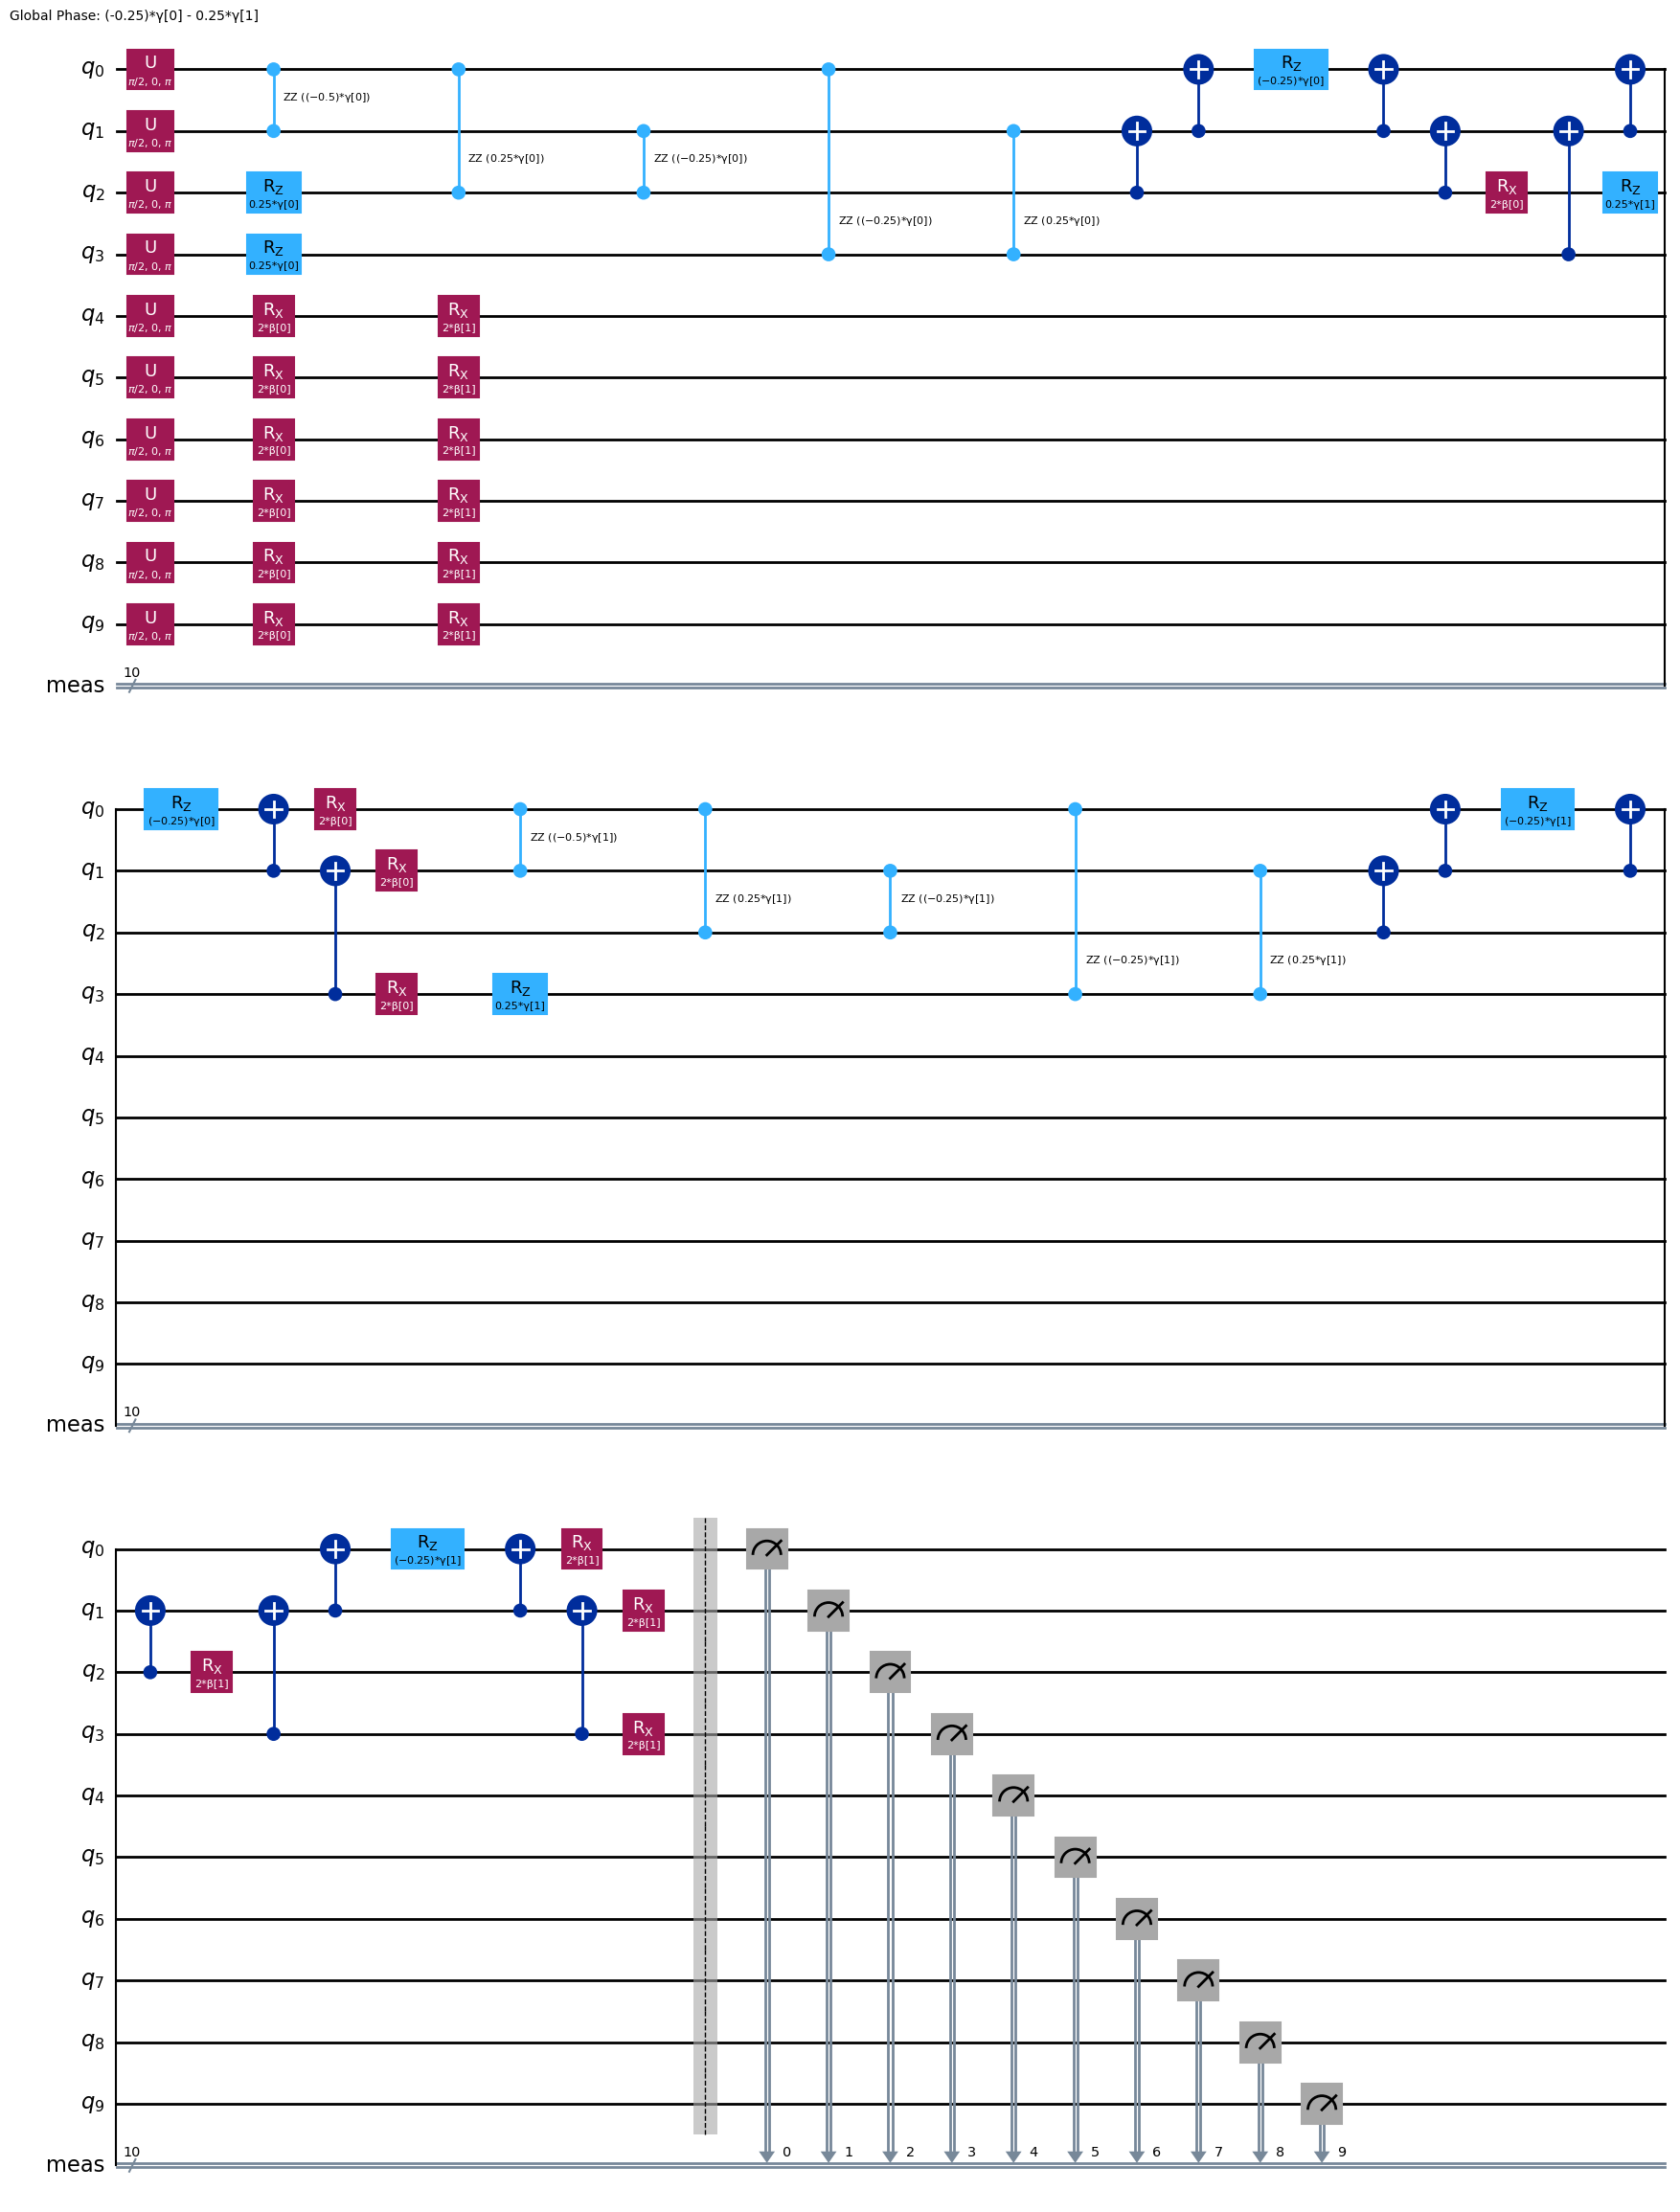

In [10]:
naive_ansatz = QAOAAnsatz(obs, reps=2)
naive_ansatz.measure_all()

naive_ansatz.decompose(reps=2).draw("mpl")

In [11]:
naive_ansatz_isa = transpile(naive_ansatz, backend=backend)

In [12]:
naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [17]:
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, estimator, naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.1318359375
Iters 2: Current cost: 0.421875
Iters 3: Current cost: 0.306640625
Iters 4: Current cost: 0.39453125
Iters 5: Current cost: 0.0712890625
Iters 6: Current cost: 0.150390625
Iters 7: Current cost: 0.044921875
Iters 8: Current cost: 0.154296875
Iters 9: Current cost: 0.40625
Iters 10: Current cost: 0.12890625
Iters 11: Current cost: 0.7109375
Iters 12: Current cost: 0.0634765625
Iters 13: Current cost: 0.6318359375
Iters 14: Current cost: 0.2001953125
Iters 15: Current cost: 0.08203125
Iters 16: Current cost: 0.041015625
Iters 17: Current cost: 0.1103515625
Iters 18: Current cost: 0.041015625
Iters 19: Current cost: 0.0458984375
Iters 20: Current cost: 0.064453125
Iters 21: Current cost: 0.046875
Iters 22: Current cost: 0.0380859375
Iters 23: Current cost: 0.0400390625
Iters 24: Current cost: 0.0517578125
Iters 25: Current cost: 0.052734375
Iters 26: Current cost: 0.046875
Iters 27: Current cost: 0.046875
Iters 28: Current cost: 0.046875
Iters 29: Curre

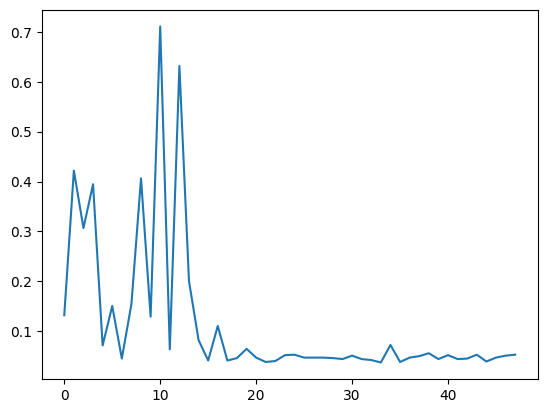

In [18]:
plt.plot(naive_cost_history_dict["cost_history"])